                epochtime       CH0       CH1       CH2       CH3       CH4  \
0     2025-02-25 09:25:32  3.231234  2.999365  2.071606  2.081124  9.225171   
1     2025-02-25 09:25:32  3.224954  2.983346  2.069020  2.084831  9.234220   
2     2025-02-25 09:25:32  3.227574  2.992332  2.073971  2.084255  9.222578   
3     2025-02-25 09:25:32  3.229105  2.985596  2.086919  2.086533  9.228596   
4     2025-02-25 09:25:32  3.229379  2.994838  2.065409  2.080534  9.224010   
...                   ...       ...       ...       ...       ...       ...   
17995 2025-02-25 10:25:49  3.220016  2.979470  2.074193  2.081527  9.232665   
17996 2025-02-25 10:25:50  3.229530  2.992131  2.079477  2.092843  9.228611   
17997 2025-02-25 10:25:50  3.221082  2.981605  2.087187  2.086886  9.237150   
17998 2025-02-25 10:25:50  3.228561  2.988963  2.072320  2.088824  9.225096   
17999 2025-02-25 10:25:50  3.219511  2.980773  2.075560  2.091035  9.229384   

            CH5       CH6       CH7       CH8      

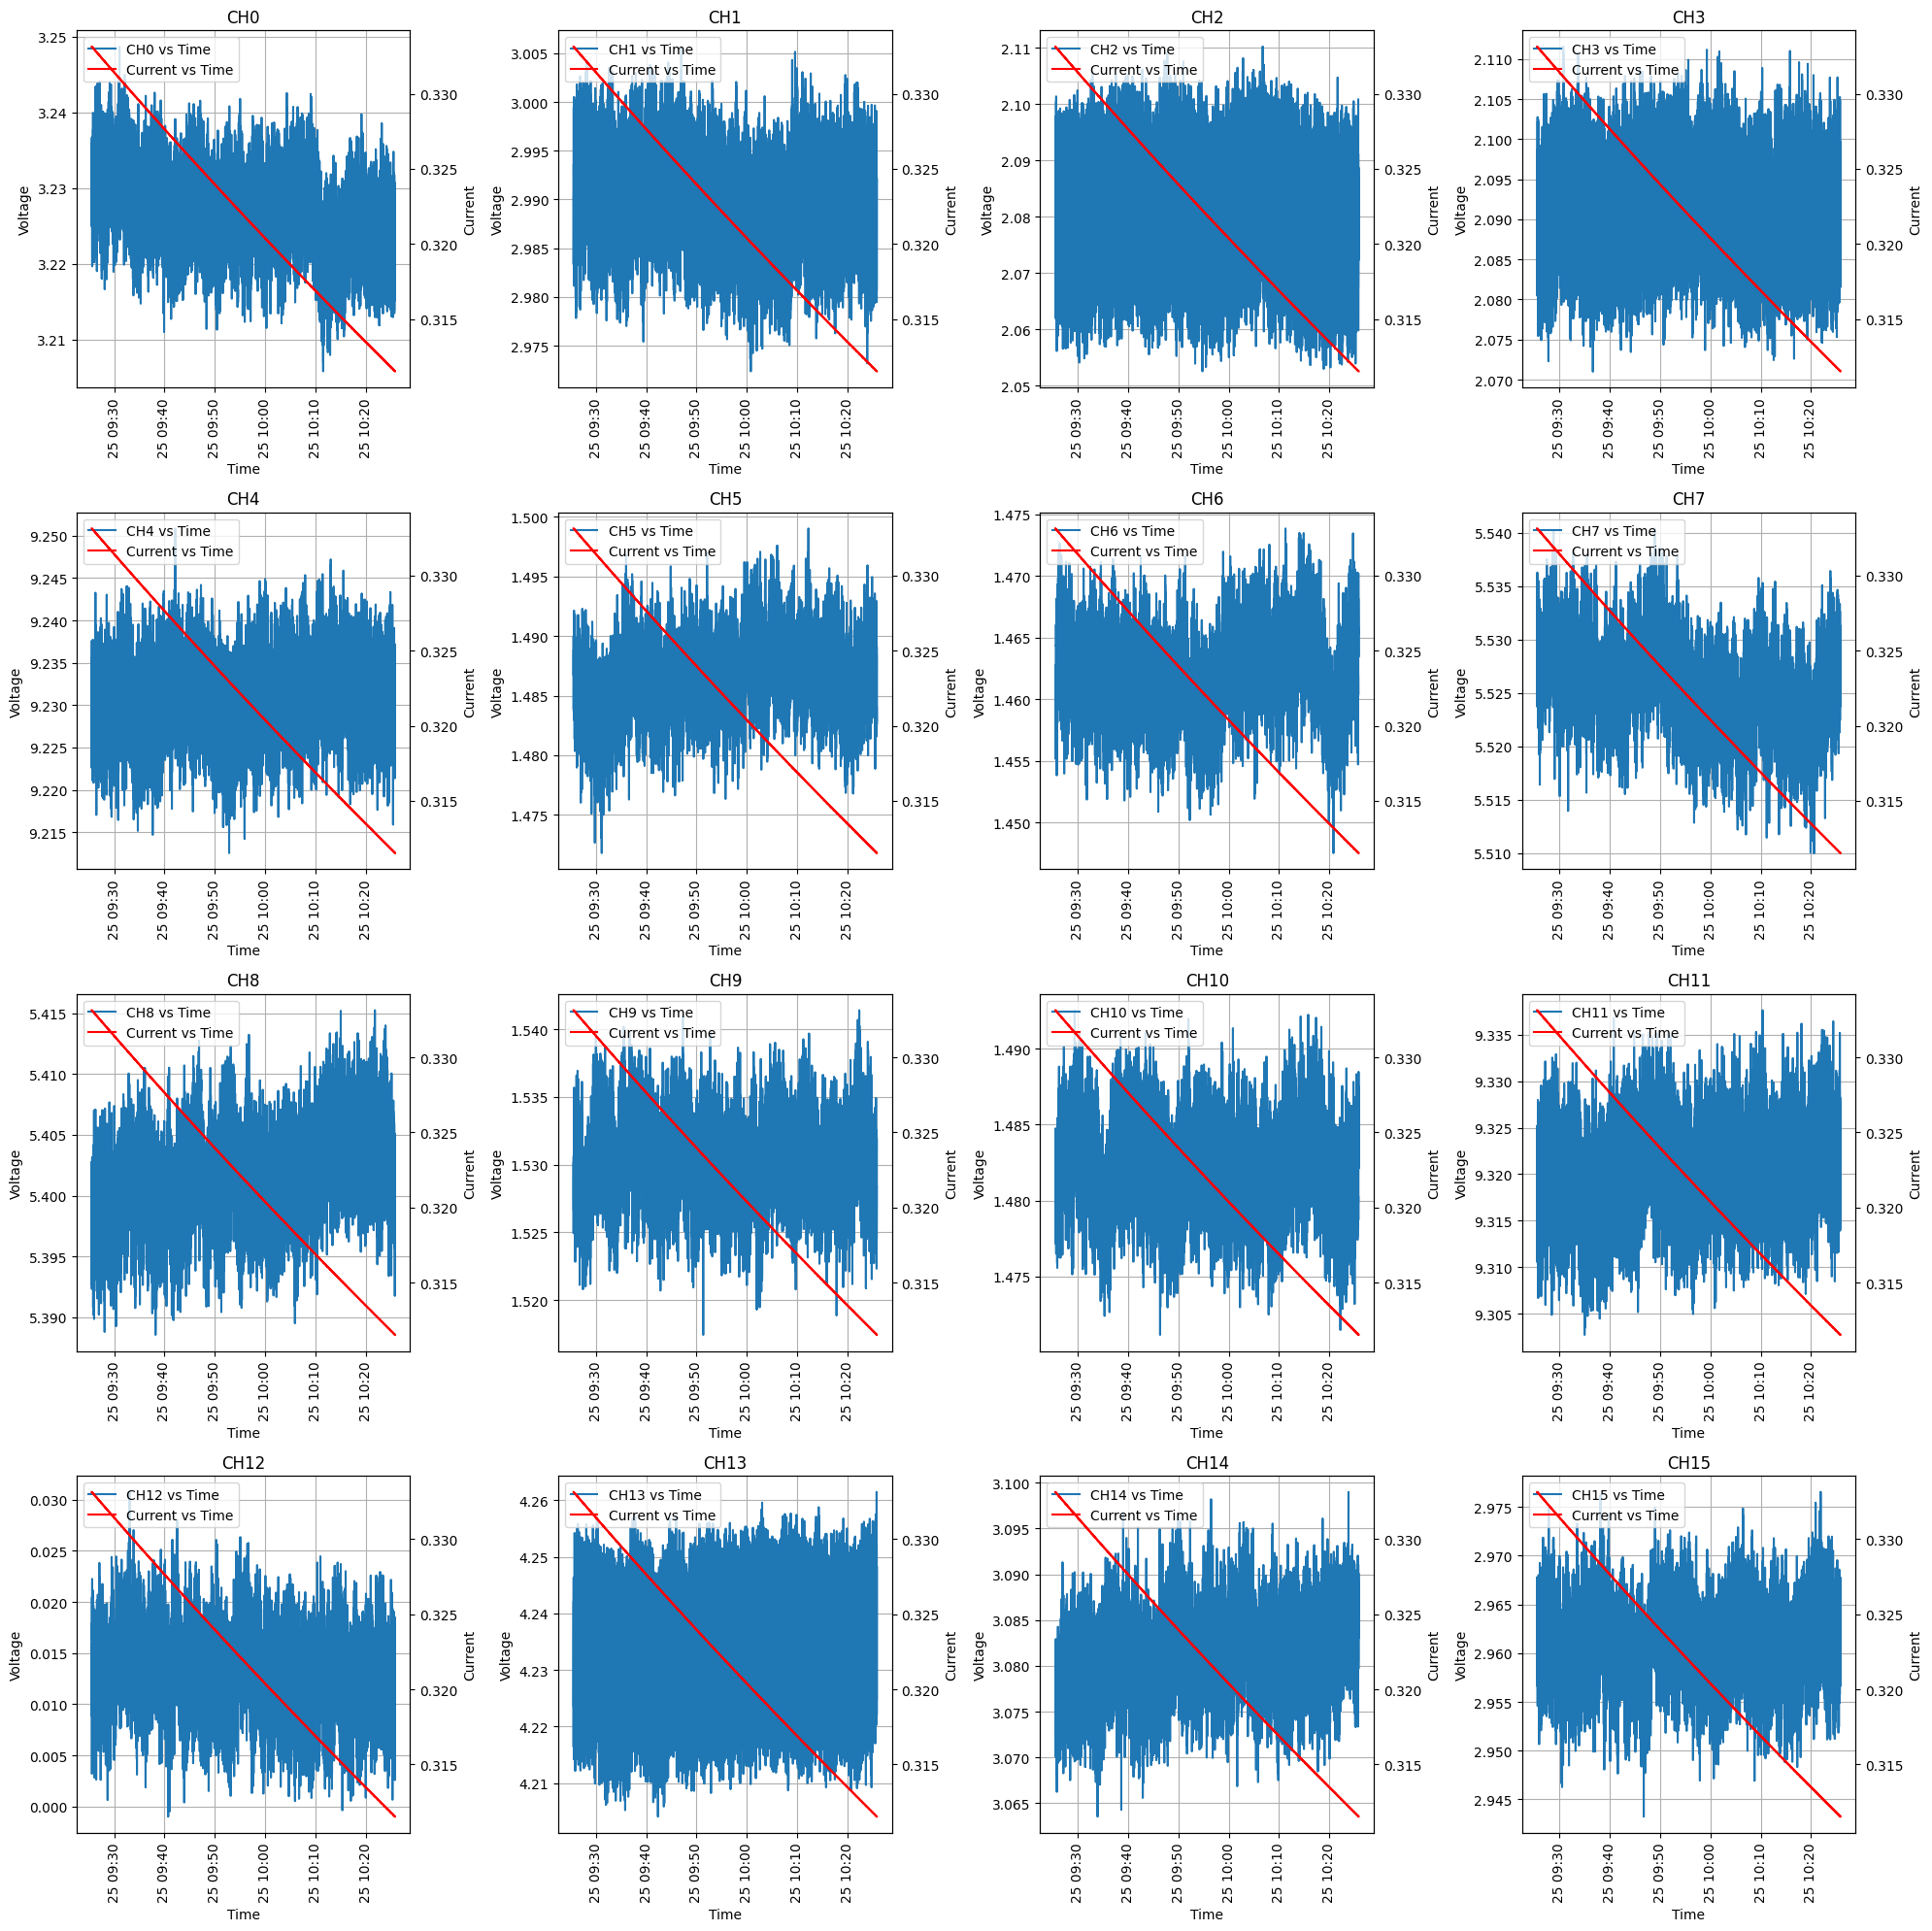

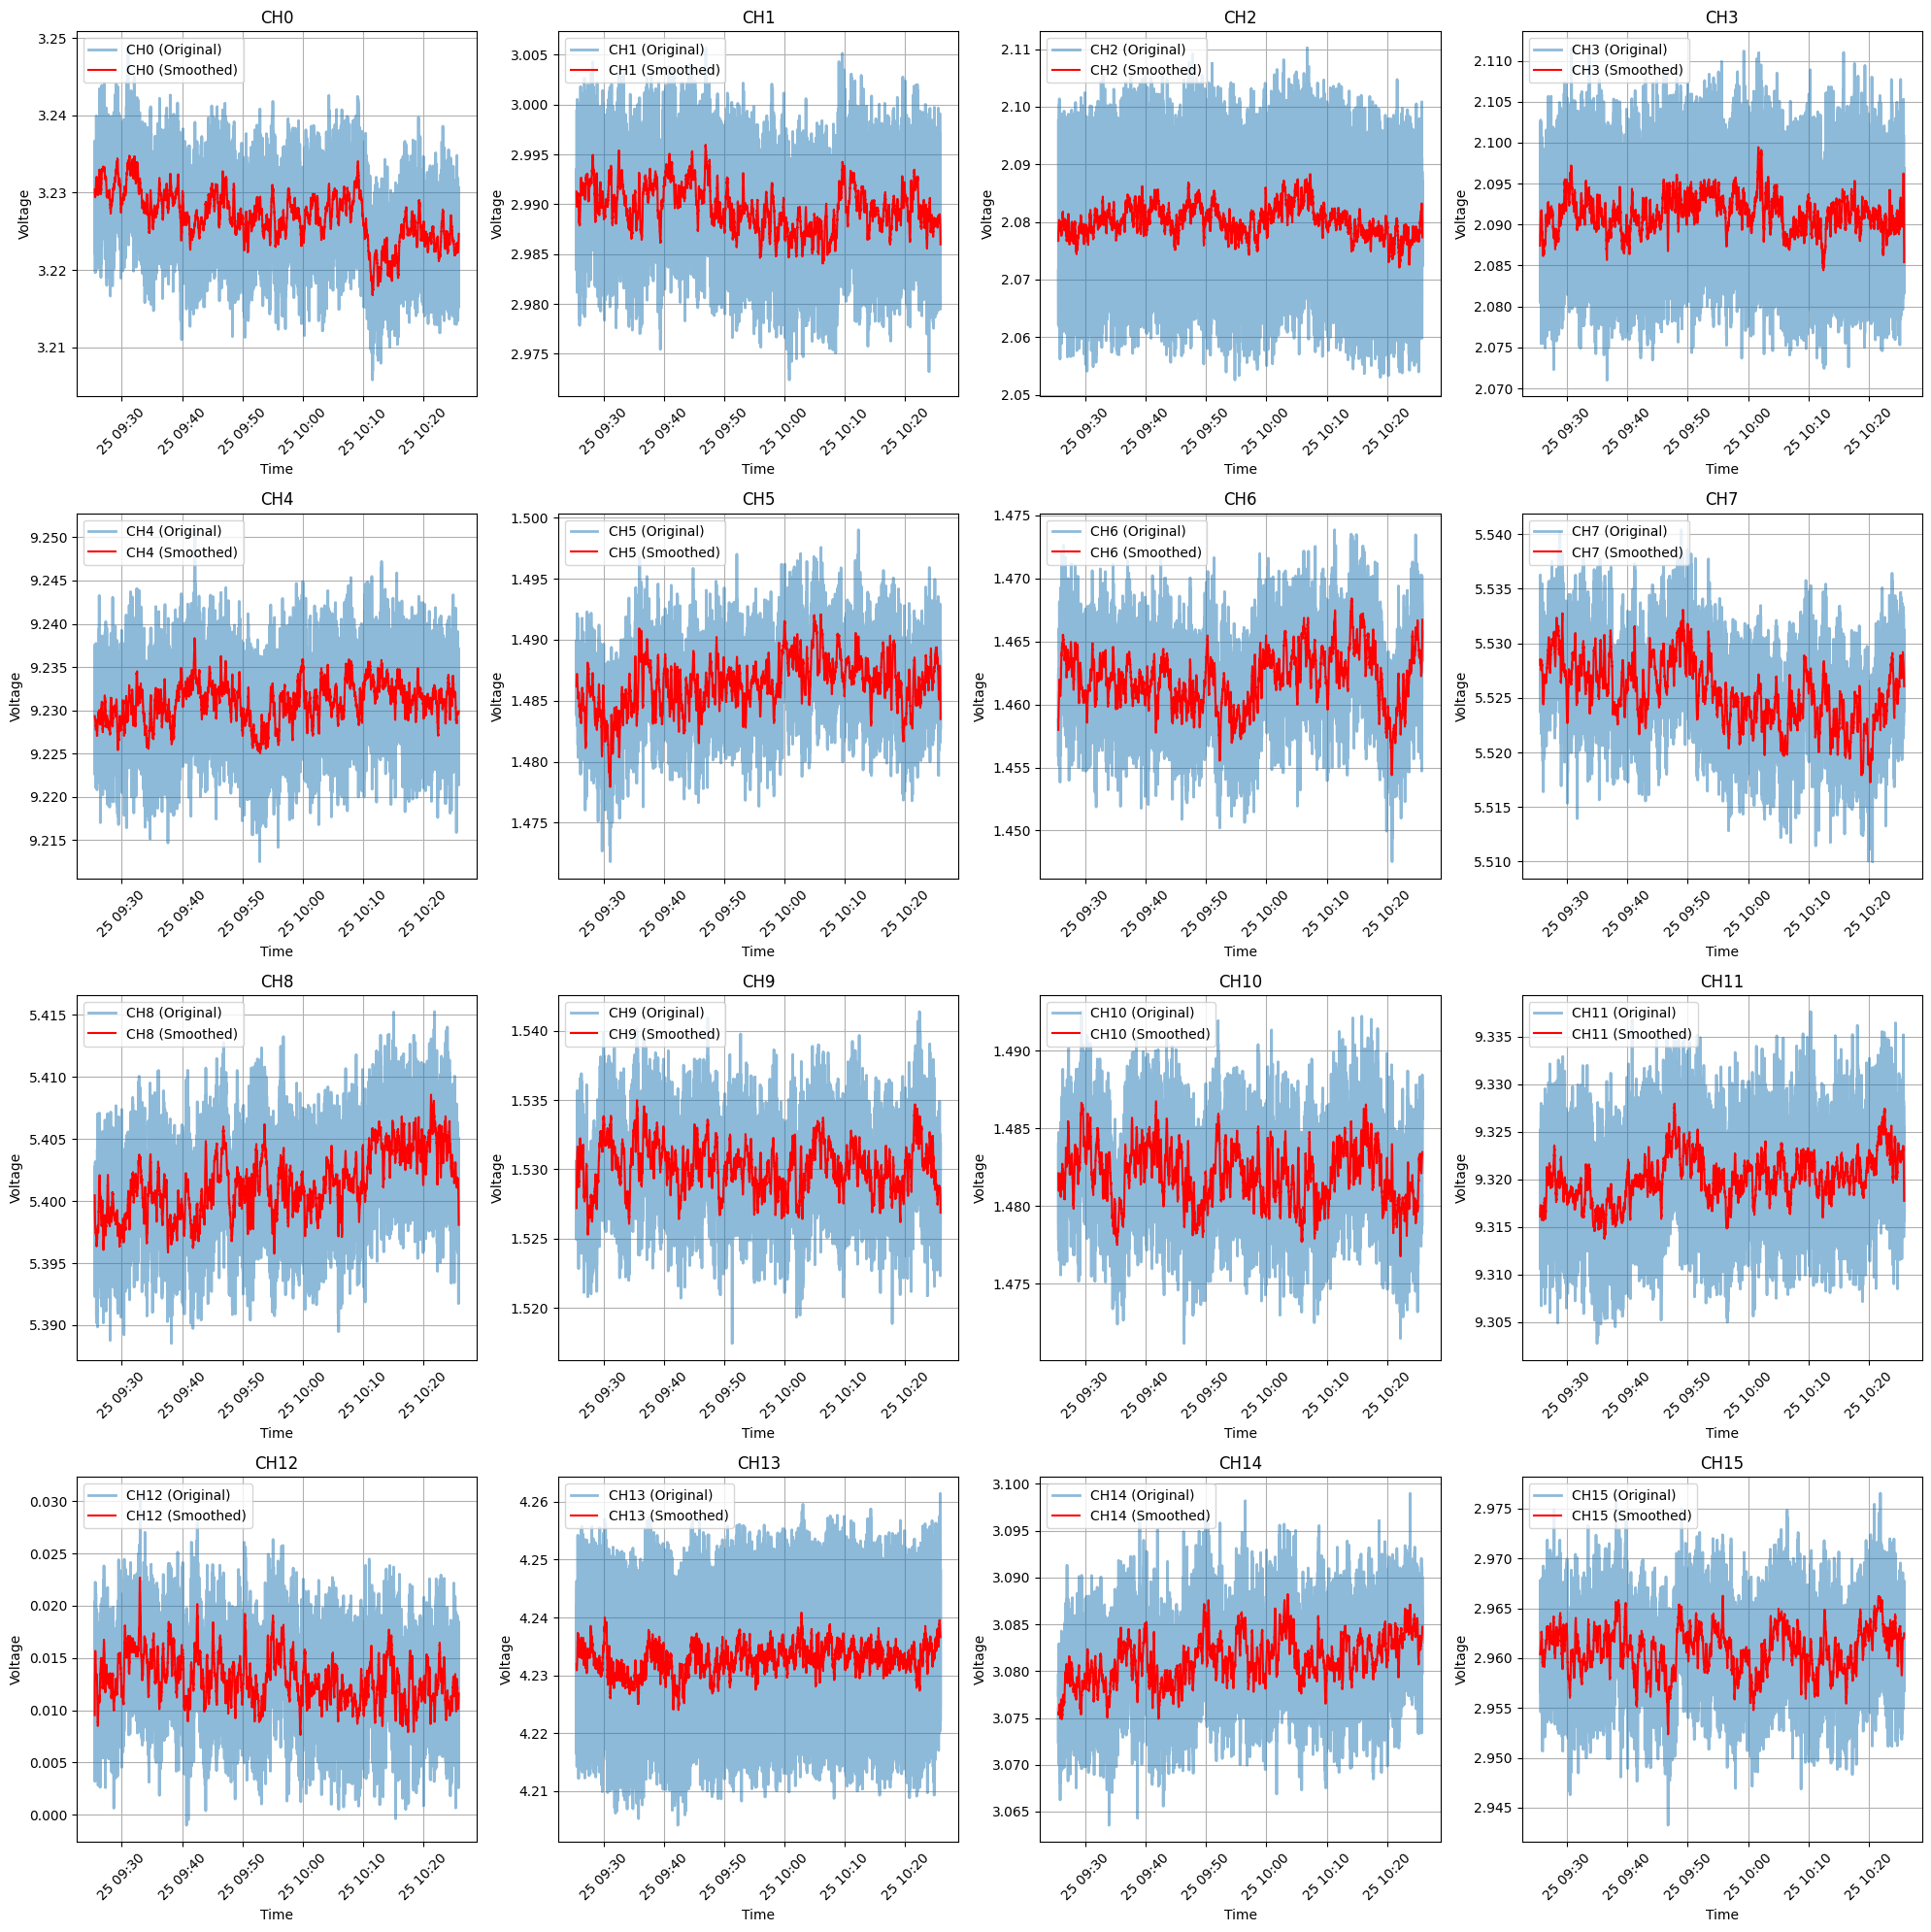

In [ ]:
import pandas as pd
import matplotlib.pyplot  as plt
import json
#import numpy as np
from scipy.signal import savgol_filter

filename = 'espsonda_12-19-58_25-02-2025'

with open(f'measurements\\{filename}.json') as json_file:
    json_decoded = json.load(json_file)

# with open('espsonda_09-42-16_29-01-2025.json') as json_file_2:
#     json_decoded_2 = json.load(json_file_2)

# Assuming json_decoded["board"] contains all channel data
channels = [f"CH{i}" for i in range(16)]  # List of channels CH0 to CH15

# Extracting voltage values for each channel
channel_values = {channel: [entry[0]["voltages"].get(channel, None) for entry in json_decoded["board"]] for channel in channels}


# Creating the DataFrame
df = pd.DataFrame({
    "epochtime": json_decoded["epochtime"],
    **channel_values,
    "current": json_decoded["current"]
})

# Convert epochtime to datetime
df['epochtime'] = pd.to_datetime(df['epochtime'], unit='s')

#df = df.truncate(after = 2400)
#df = df.truncate(before = 1000)

# Print the DataFrame
print(df)

# Plotting all channels
fig = plt.figure(figsize=(20, 20))  # Adjust the figure size for better visibility

for i, channel in enumerate(channels):
    ax1 = plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 subplots
    ax1.plot(df["epochtime"], df[channel], label=f"{channel} vs Time")
    ax1.set_ylabel("Voltage")

    ax2 = ax1.twinx()
    ax2.plot(df["epochtime"], df["current"], color='r', label=f"Current vs Time")
    ax2.set_ylabel("Current")

    ax1.set_title(channel)
    ax1.set_xlabel("Time")
    ax1.tick_params(axis='x', rotation=90)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    #plt.legend()
    
    ax1.grid()
    plt.tight_layout()
plt.savefig(f'graphs\\{filename}_1.png')
plt.show()


# Apply Savitzky-Golay filter to smooth the data
smoothed_data = {}
for channel in channels:
    signal = df[channel]#.dropna()  # Remove NaN values
    smoothed_signal = savgol_filter(signal, 101, 3)  # Window size 101, polynomial order 3
    smoothed_data[channel] = smoothed_signal

# Add smoothed data to DataFrame
for channel, smoothed_signal in smoothed_data.items():
    df[f"{channel}_smoothed"] = smoothed_signal

# Plot the original and smoothed data for each channel
plt.figure(figsize=(20, 20))  # Adjust the figure size for better visibility
for i, channel in enumerate(channels):
    plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 subplots
    plt.plot(df["epochtime"], df[channel], linestyle='-', linewidth=2, alpha=0.5, label=f"{channel} (Original)")
    plt.plot(df["epochtime"], df[f"{channel}_smoothed"], color='r', label=f"{channel} (Smoothed)")
    plt.title(channel)
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.ylabel("Voltage")
    plt.legend(loc=2)
    plt.grid()
    plt.tight_layout()
plt.savefig(f'graphs\\{filename}_2.png')
plt.show()


# Sampling frequency (Hz) - adjust this based on your data
# fs = 10  # Example: 10 samples per second

# # Plotting the FFT of all channels
# plt.figure(figsize=(20, 20))  # Adjust the figure size for better visibility

# for i, channel in enumerate(channels):
#     # Remove NaN values from the channel for FFT
#     signal = df[channel].dropna()

#     # Perform FFT
#     n = len(signal)
#     freqs = np.fft.rfftfreq(n, d=1/fs)  # Frequency bins
#     fft_values = np.fft.rfft(signal)    # FFT values
#     magnitude = np.abs(fft_values)      # Magnitude of FFT
    
#     # Plot FFT
#     plt.subplot(4, 4, i + 1)  # 4x4 grid for 16 subplots
#     plt.plot(freqs, magnitude, label=f"FFT of {channel}")
#     plt.title(f"FFT of {channel}")
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude")
#     plt.legend()
#     plt.tight_layout()

# plt.show()

